## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

In [1]:
!pip install tqdm

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [2]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [3]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

In [6]:
#defult state and valid actions
env = TicTacToe()
print(Q_state(env.state))

valid_actions(env.state)


x-x-x-x-x-x-x-x-x


[(0, 1),
 (0, 3),
 (0, 5),
 (0, 7),
 (0, 9),
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 7),
 (1, 9),
 (2, 1),
 (2, 3),
 (2, 5),
 (2, 7),
 (2, 9),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 7),
 (3, 9),
 (4, 1),
 (4, 3),
 (4, 5),
 (4, 7),
 (4, 9),
 (5, 1),
 (5, 3),
 (5, 5),
 (5, 7),
 (5, 9),
 (6, 1),
 (6, 3),
 (6, 5),
 (6, 7),
 (6, 9),
 (7, 1),
 (7, 3),
 (7, 5),
 (7, 7),
 (7, 9),
 (8, 1),
 (8, 3),
 (8, 5),
 (8, 7),
 (8, 9)]

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [7]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    max_epsilon = 1.0
    min_epsilon = 0.001
    decay_rate=0.000001
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    z = np.random.random()
        
    if z > epsilon:
        action = max(Q_dict[Q_state(state)],key=Q_dict[Q_state(state)].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        #print('state for random',state,'\n')
        action = random.choice(valid_actions(state))    #Exploration: randomly choosing and action
        #print('random action',action)
    
    return action


#### Tracking the state-action pairs for checking convergence - write your code here

In [8]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

#for pre trained package
# with open('Policy.pkl', 'rb') as handle:
#     Q_dict = pickle.load(handle)
   
# with open('States_tracked.pkl', 'rb') as handle:
#     States_track = pickle.load(handle)    

Q_dict

defaultdict(dict, {})

In [9]:
# Initialise states to be tracked
sample_q_values = [('x-3-x-x-x-6-x-x-x',(0,1)),
                       ('x-1-x-x-x-x-8-x-x',(2,9)),
                       ('x-x-x-x-6-x-x-x-5',(2,7)),
                       ('x-x-x-x-9-x-6-x-x',(1,7)),
                       ('x-5-x-2-x-x-4-7-x',(0,9)),
                       ('9-x-x-x-x-2-x-x-x',(2,5)),
                       ('x-x-7-x-x-x-x-x-2',(1,5))]
def initialise_tracking_states():
    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [10]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [11]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [12]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [13]:
#Defining parameters for the experiment

EPISODES = 5000000 
LR = 0.01                   #learning rate
GAMMA = 0.91


threshold = 2000       #every these many episodes, the sample Q-values will be stored/appended (convergence graphs)
policy_threshold = 30000    #every these many episodes, the Q-dict will be updated
print_status=500000  #Print status for episodes played till now

### Q-update loop ---write your code here

In [14]:
start_time = time.time()
agent_won_count = 0
env_won_count = 0
tie_count = 0

for episode in tqdm(range(EPISODES)):
    env = TicTacToe()
    ##### Start writing your code from the next line
    curr_state = env.state
    
    is_game_ended=False
    add_to_dict(curr_state)
    
    while is_game_ended != True:
        #print('IAM HERE',is_game_ended,is_game_ended != True)
        curr_state_Q = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)   # applying epislon method
        next_state, reward, is_game_ended, msg = env.step(curr_state, curr_action) # getting reward
        #print('game ended',is_game_ended)
        add_to_dict(next_state)
        
        #print('\n','current',curr_state,curr_state_Q)
        
        next_state_Q = Q_state(next_state)
        
        
        
        if is_game_ended != True:
            max_next = max(Q_dict[next_state_Q],key=Q_dict[next_state_Q].get)  
            #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state_Q][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_Q][max_next])))
                                                      - Q_dict[curr_state_Q][curr_action] ) 
        else:
            #print(curr_state_Q,curr_action)
            if msg == "Agent Won":
                agent_won_count += 1
            elif msg == "Env Won":
                env_won_count += 1
            else:
                tie_count += 1

            Q_dict[curr_state_Q][curr_action] += LR * ((reward - Q_dict[curr_state_Q][curr_action]))

        #going to next step
        curr_state = next_state

        
    if (episode + 1) % print_status == 0:
        print("After playing %d games, Agent Won : %.4f, Environment Won : %.4f, Tie : %.4f"% (episode + 1, 
        agent_won_count / (episode + 1), env_won_count /(episode + 1), tie_count / (episode + 1)))
        
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracked')

    if ((episode+1)% policy_threshold) == 0:
        save_obj(Q_dict,'Policy')
    
    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')
print('Total Time: ',elapsed_time)

After playing 500000 games, Agent Won : 0.2631, Environment Won : 0.2783, Tie : 0.4586
After playing 1000000 games, Agent Won : 0.2940, Environment Won : 0.2640, Tie : 0.4420
After playing 1500000 games, Agent Won : 0.3300, Environment Won : 0.2501, Tie : 0.4199
After playing 2000000 games, Agent Won : 0.4130, Environment Won : 0.2191, Tie : 0.3679
After playing 2500000 games, Agent Won : 0.4982, Environment Won : 0.1872, Tie : 0.3146
After playing 3000000 games, Agent Won : 0.5636, Environment Won : 0.1625, Tie : 0.2739
After playing 3500000 games, Agent Won : 0.6147, Environment Won : 0.1431, Tie : 0.2422
After playing 4000000 games, Agent Won : 0.6553, Environment Won : 0.1276, Tie : 0.2171
After playing 4500000 games, Agent Won : 0.6879, Environment Won : 0.1151, Tie : 0.1970
After playing 5000000 games, Agent Won : 0.7146, Environment Won : 0.1048, Tie : 0.1805

Total Time:  4901.437447071075


#### Check the Q-dictionary

In [15]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.131395628263516,
              (0, 3): -1.3033088673595035,
              (0, 5): -1.3606927397362172,
              (0, 7): -1.3212621787320842,
              (0, 9): -1.3115947506588086,
              (1, 1): -1.1199614925020172,
              (1, 3): -1.20815485197195,
              (1, 5): -1.3339123501573107,
              (1, 7): -1.276148974828891,
              (1, 9): -1.2617560197921094,
              (2, 1): -1.324900994810683,
              (2, 3): -1.3389303427947308,
              (2, 5): -1.376142242719304,
              (2, 7): -1.2662115346709957,
              (2, 9): -1.3064232040547967,
              (3, 1): -1.3525556349537262,
              (3, 3): -1.2705547044081649,
              (3, 5): -1.3066474732770472,
              (3, 7): -1.3081336293168395,
              (3, 9): 5.636766767507215,
              (4, 1): -1.3081587963902452,
              (4, 3): -1.3705949699599944,
              (4, 5): -

In [16]:
len(Q_dict)

2269807

In [17]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
Q_dict['x-x-x-x-3-x-x-x-4']


{(0, 1): -0.5193283717545109,
 (0, 5): -0.515604753001819,
 (0, 7): -0.5160439457067121,
 (0, 9): -0.5178459448687815,
 (1, 1): -0.5779404213887924,
 (1, 5): -0.5858364585527787,
 (1, 7): -0.6218843124509711,
 (1, 9): -0.5345021442866239,
 (2, 1): -0.5400862294925506,
 (2, 5): -0.516280072665314,
 (2, 7): -0.6079779136333938,
 (2, 9): -0.5620956044091475,
 (3, 1): -0.5431382486512188,
 (3, 5): -0.5489532909433383,
 (3, 7): -0.5197809734091717,
 (3, 9): -0.5787476343811571,
 (5, 1): -0.5789941293892076,
 (5, 5): -0.6373562116226769,
 (5, 7): -0.5200801032050324,
 (5, 9): -0.5177520590315161,
 (6, 1): -0.6024528831065209,
 (6, 5): -0.5590339726986627,
 (6, 7): -0.5168709479343,
 (6, 9): -0.542796813095108,
 (7, 1): -0.5808164835247288,
 (7, 5): -0.5752237188108357,
 (7, 7): -0.5755757526715749,
 (7, 9): -0.5734899841375025}

#### Check the states tracked for Q-values convergence
(non-evaluative)

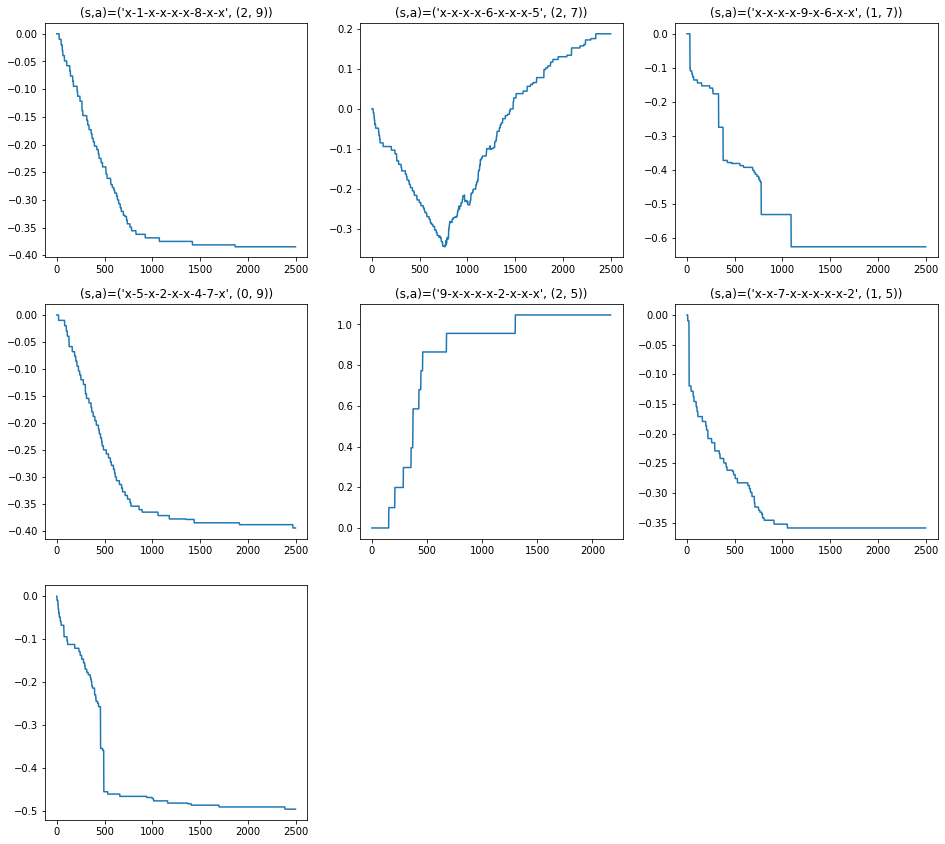

In [18]:
# Write the code for plotting the graphs for state-action pairs tracked
plt.figure(0, figsize=(16,25))



for index in range(len(sample_q_values)):
    x_axis = np.asarray(range(0, len(States_track[sample_q_values[index][0]][sample_q_values[index][1]])))
    plt.title("(s,a)=" + str(sample_q_values[index]))
    plt.subplot(5,3,index+1)
    plt.plot(x_axis,np.asarray(States_track[sample_q_values[index][0]][sample_q_values[index][1]]))
    plt.show
    


### Epsilon - decay check

In [19]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

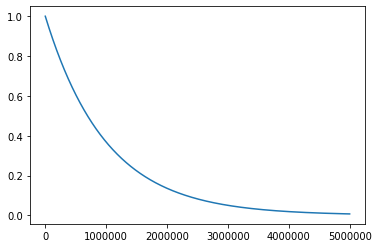

In [20]:
plt.plot(time, epsilon)
plt.show()